In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('train.csv')

In [4]:
df = data.copy()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
# Dropping the columns in train set with lots of missing values
df = df.drop(['Alley', 'FireplaceQu',
              'PoolQC', 'Fence', 
              'MiscFeature'], axis=1)

In [7]:
# Dropping the ID column
df = df.drop(['Id'], axis = 1)

In [8]:
# Categorical columns
categorical = ['MSZoning', 'Street','LotShape',
           'LandContour', 'Utilities', 'LotConfig',
           'LandSlope', 'Neighborhood', 'Condition1',
           'Condition2', 'BldgType', 'HouseStyle',
           'RoofStyle', 'RoofMatl', 'Exterior1st',
           'Exterior2nd', 'MasVnrType','ExterQual', 
           'ExterCond', 'Foundation', 'BsmtQual', 
           'BsmtCond','BsmtExposure','BsmtFinType1',
           'BsmtFinType2', 'Heating','HeatingQC', 
           'CentralAir', 'Electrical',
           'KitchenQual', 'Functional', 'GarageType',
           'GarageFinish' ,'GarageQual', 'GarageCond', 'PavedDrive',
           'SaleType', 'SaleCondition']

In [9]:
# Filling the missing values as "Not Assigned"
df[categorical] = df[categorical].fillna("Not Assigned")

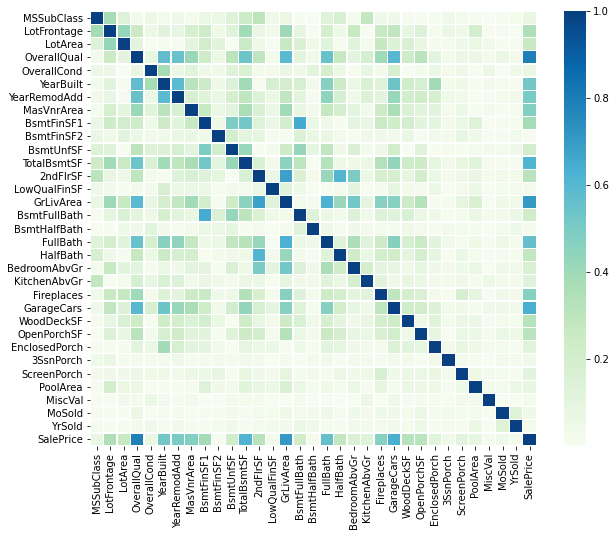

In [10]:
# Correlation matrix with absolute vals
correlation_mat = df.corr().abs()
# Selecting upper triangle of correlation matrix
upper = correlation_mat.where(np.triu(np.ones(correlation_mat.shape), 
                                  k=1).astype(np.bool))
# Finding the features with correlation greater than 0.80
to_drop = [column for column in upper.columns if any(
        upper[column] > 0.80)]
# Dropping those features 
df = df.drop(to_drop, axis=1)

# New correlation matrix with absolute vals with dummy variables
correlation_mat = df.corr().abs()
# Correlation matrix heat map
plt.figure(figsize=(10,8))
sns.heatmap(correlation_mat, annot = False, linewidths=.3, cmap ="GnBu")
plt.show()

In [11]:
# Creating the dummy variables for categorical features and
# avoiding the dummy variable trap by setting drop_first parameter as True.
df = pd.get_dummies(df, columns = categorical, drop_first=True)

In [12]:
# Filling the missing values with mean values
for col in df.columns:
    df[col] = df[col].fillna(df[col].mean()) 

In [13]:
# Removing duplicates if exists
df = df.drop_duplicates()

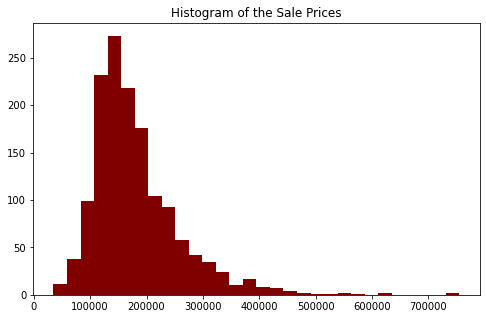

In [14]:
# Histogram of SalePrice column
plt.figure(figsize=(8,5))
plt.hist(df['SalePrice'], bins = 30, color = 'maroon')
plt.title('Histogram of the Sale Prices')
plt.show()

In [15]:
df.shape

(1460, 240)

In [16]:
X = df.drop(['SalePrice'], axis =1)
Y = df['SalePrice']

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
testSize = 0.2
x_train, x_test, y_train, y_test = train_test_split(
        X, Y, test_size=testSize, random_state = 4)

In [19]:
from xgboost import XGBRegressor

In [20]:
xgb = XGBRegressor()

In [21]:
# Hyperparameter tuning
parameters = {
    'booster': ['gbtree', 'gblinear'],
    'max_depth' : [2,3,4,5,10],
    'learning_rate': [0.05, 0.1, 0.20],
    'n_estimators': [100,500,1000,1500, 2000],
    'min_child_weight': [1,2,3],
    'base_score': [0.25,0.5,0.75,1] 
}

In [22]:
from sklearn.model_selection import RandomizedSearchCV

In [23]:
randomCV = RandomizedSearchCV(estimator = xgb,
                             param_distributions = parameters,
                             cv = 3,
                              n_iter=25,
                              scoring = 'neg_mean_absolute_error',
                              n_jobs = 3,
                              verbose = True,
                              return_train_score = True,
                              random_state = 1)

In [24]:
randomCV.fit(x_train,y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                                          validate_parameters=None,
                                          verbosity=None),
                   n_iter=25, n_jobs=3,
                   para

In [25]:
randomCV.best_estimator_

XGBRegressor(base_score=1, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [26]:
xgb = XGBRegressor(base_score=1, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=2,
             min_child_weight=1, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [27]:
xgb.fit(x_train,y_train)

XGBRegressor(base_score=1, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [28]:
prediction = xgb.predict(x_test)

In [29]:
from xgboost import plot_importance

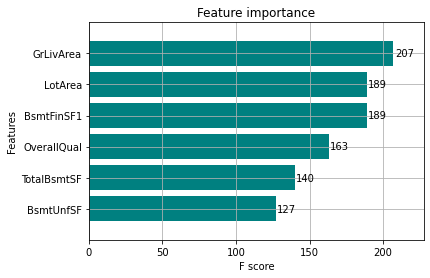

In [30]:
# Most important features
plot_importance(xgb, height=.8,max_num_features = 6, color = 'teal')
plt.show()

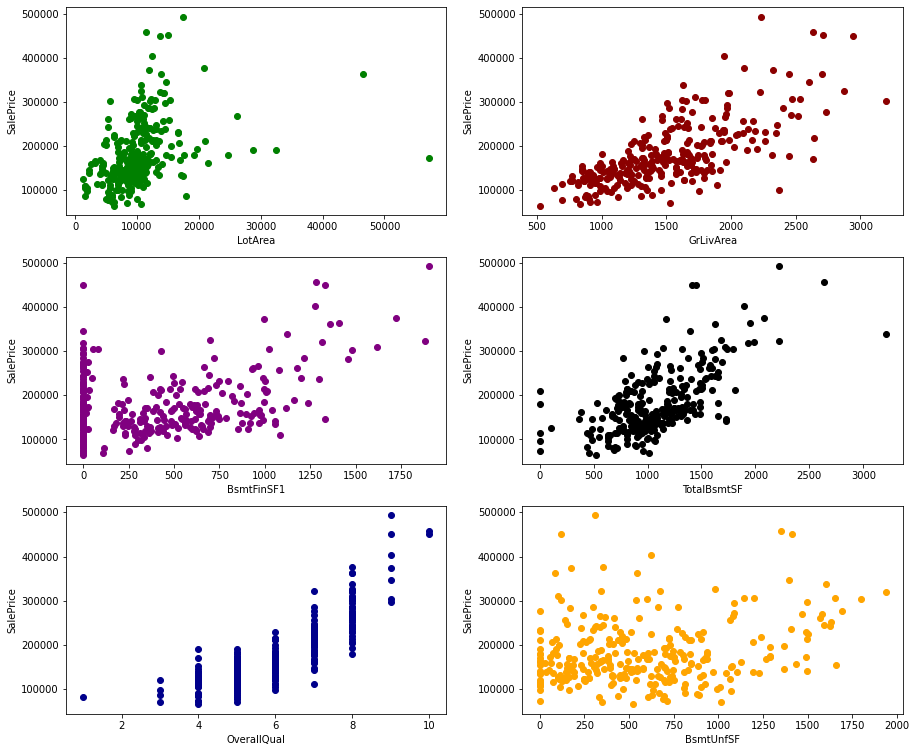

In [31]:
plt.figure(figsize=(15,13))

plt.subplot(321)
plt.scatter(x_test['LotArea'], prediction, color = 'green')
plt.xlabel('LotArea')
plt.ylabel('SalePrice')

plt.subplot(322)
plt.scatter(x_test['GrLivArea'], prediction, color = 'darkred')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')

plt.subplot(323)
plt.scatter(x_test['BsmtFinSF1'], prediction, color = 'purple')
plt.xlabel('BsmtFinSF1')
plt.ylabel('SalePrice')

plt.subplot(324)
plt.scatter(x_test['TotalBsmtSF'], prediction, color = 'black')
plt.xlabel('TotalBsmtSF')
plt.ylabel('SalePrice')

plt.subplot(325)
plt.scatter(x_test['OverallQual'], prediction, color = 'darkblue')
plt.xlabel('OverallQual')
plt.ylabel('SalePrice')

plt.subplot(326)
plt.scatter(x_test['BsmtUnfSF'], prediction, color = 'orange')
plt.xlabel('BsmtUnfSF')
plt.ylabel('SalePrice')

plt.show()

In [32]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score

In [33]:
rmse  = np.sqrt(mean_squared_error(y_test, prediction))
rmsle = np.sqrt(mean_squared_log_error(y_test, prediction))
r2 = r2_score(y_test,prediction)

print("RMSE  :", rmse)
print("RMSLE :", rmsle)
print("R²    :", r2)

RMSE  : 22333.11787396369
RMSLE : 0.11797326939860411
R²    : 0.9101644512337819
